# Práctica I

## Extracción de los datos

### Funciones de utilidad

Importación de las librerías necesarias

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import requests, json
from IPython.display import IFrame

Se crea la función **`get_raw_data_frame`** que permite extrare el dataframe de PANDAs a partir del código del juego de datos. El segundo de los argumentos es para poder soportar que la respuesta sea devuleta comprimida.

In [2]:
def get_raw_data_frame( key, gziped ): 
    
    # url_template = 'https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/%s$DEFAULTVIEW/?format=TSV&compressed=false' 
    
    url_template =  'https://ec.europa.eu/eurostat/databrowser-backend/api/extraction/1.0/LIVE/false/tsv/%s?i'

    url = url_template % key

    return pd.read_table( url, compression = 'gzip' ) if gziped else  pd.read_table(  url )


Función de flujo de datos: **`extract_country`**

Extraer el país a partir de la primera columna del dataframe

In [3]:
def extract_country( data ):
    
    new_data = data.rename( columns={data.iloc[:, 0].name :'country'} )

    new_data['country'] = new_data['country'].str.replace(r'^.*,(.*)$', r'\1', regex=True)
    
    return new_data


Función de flujo de datos: **`trim_column_names`**

Eliminar espacios en los nombres de las columnas

In [4]:
def trim_column_names( data ):
    
    for col in data.columns:
    
        data = data.rename( columns={col :col.strip()} )
    
    return data
    

Función de flujo de datos: **`clean_numeric_columns`**

Limpia, trata y transforma todas las columnas que son númericas

In [5]:
def clean_numeric_columns( data ):
   
   data.iloc[:,1:] = data.iloc[:,1:].replace(
        r'^.*[:].*$', None, regex=True # Not available and confidencial flag
   ).replace(
        r'e', '', regex=True # Remove flag estimated
   ).replace(
        r'd', '', regex=True # Remove flag definition differs
   ).replace( 
        r'^(.+) +$', r'\1', regex = True # rTrim
   ).replace( 
        r'^ +(.+)$', r'\1', regex = True # lTrim>
   )
   
   for col in  data.iloc[:,1:].columns :    
        data[col] = pd.to_numeric( data[col] )
    
   return data
    
    

Función de flujo de datos: **`filter_data`**

Función que filtra los registros que cumplann la condión del filtro en la primera de las columnas

In [6]:
def filter_data( filter ): 
    def _filter_data( data ):
        new_data = data[data.iloc[:, 0].str.contains( filter )]    
        new_data.reset_index(inplace = True, drop = True)
        return new_data
    return _filter_data
    

Función que obtiene el maestro de países (**`get_country_names`**), que permite obtener el nombre del país a partir de su identificador

In [7]:
def get_country_names():
    url = requests.get("https://ec.europa.eu/eurostat/databrowser-backend/api/codelist/LIVE/GEO/getCodeListJson/9.0/ESTAT/en/false")
    text = url.text
    data = json.loads(text)
    return data['category']['label']


Función de flujo de datos: **`add_column_country_name_flow`**

Función que añade la columna con el nombre de los países

In [8]:
def add_column_country_name_flow():    
    
    def _add_column_country_name(data) : 
        country_names = get_country_names()    
        data.insert(
            1, 
            'country_name', 
            data.country.map(lambda v: country_names[v] ), 
            True
        )
        return data
    
    return _add_column_country_name 

Función **`export_dataframe`** que permite exportar el dataframe a fichero CSV

In [10]:
def export_dataframe( df, file_name, directory ):
    #file = 'C:\Python_Projects\TipologiaYCicloDeVidaDelDato\Data\%s/%s.csv' % (directory, file_name )
    file = '/home/jovyan/work/%s/%s.csv' % (directory, file_name )
    df.to_csv(file )
    
    

#### Flujo de procesamiento de datos de los dataset auxiliares

Función que realiza todo el proceso de extración y limpieza de los datos.

La función **`flow`** define, por composición de funciones, el flujo procesamiento que se va a realizar después de la carga de cada subdataframe después de su obtención a partir de la petición HTTP:

1) Filtrará los datos por el filtro
2) Obtendrá la columna de los identificadores de los paises a partir de la informaciónb de la primera columna
3) Eliminará los espacios de los nombres de las columnas de los dataframe
4) Procesará todas aquellas columnas relativas a los años para que contengan datos númericos
5) Se añade la columna con la descripción del país

La función **`dataframe_by_key`** combina la obtención del dataframe con su procesamiento posterior

In [9]:
class Compose:
    _f = None
    def __init__(self, f):
        self._f = f
    def andThen( self, g ):
        return Compose( lambda s: ( g( self._f(s) ) ) )
    def apply(self, a): 
        return self._f( a )
    
column_country_name = add_column_country_name_flow()    

def flow( filter ) :
    return Compose( 
        filter_data( filter )
    ).andThen(
        extract_country
    ).andThen(
        trim_column_names 
    ).andThen( 
        clean_numeric_columns 
    ).andThen( 
        column_country_name
    )

def dataframe_by_key( key, filter, gziped = False ):
        return flow(filter).apply(  get_raw_data_frame( key, gziped ) )


### _DATASET I_: Precio de Gas doméstico en € por kw/h

Obtenido del origen de datos [Gas prices components for household consumers - annual data](https://ec.europa.eu/eurostat/databrowser/view/nrg_pc_202_c/default/table?lang=en)

Clave de identificación de los datos: **`NRG_PC_202_C`**

Se filtrarán los datos por:

 - Datos anuales
 - Componentes del precio de la energia: _"Energia y suministro "_
 - Consumición de la energía: En Giga Julios en todas las bandas
 - Moneda: Euro (€)
 - Unidad de medida: Kiolwatio-hora

In [11]:
data_gas_prices_household_consumers = dataframe_by_key( 
    key    = 'NRG_PC_202_C', 
    filter = 'A,NRG_SUP,TOT_GJ,EUR,KWH'
) 

Columnas del dataset:

In [12]:
display( data_gas_prices_household_consumers.dtypes )

country          object
country_name     object
2017            float64
2018            float64
2019            float64
2020            float64
2021            float64
dtype: object

Se muestran los 10 primeros valores:

In [13]:
data_gas_prices_household_consumers.head( 10 )

,country,country_name,2017,2018,2019,2020,2021
0,AT,Austria,0.0299,0.0304,0.0312,0.0308,0.0316
1,BA,Bosnia and Herzegovina,0.0240,0.0240,0.0249,0.0258,0.0251
2,BE,Belgium,0.0283,0.0288,0.0289,0.0252,0.0315
3,BG,Bulgaria,0.0170,0.0209,0.0240,0.0177,0.0331
4,CZ,Czechia,0.0360,0.0390,0.0455,0.0431,0.0448
5,DE,Germany (until 1990 former territory of the FRG),NaN,NaN,0.0278,0.0292,0.0293
6,DK,Denmark,0.0234,0.0259,0.0209,0.0160,0.0415
7,EA,"Euro area (EA11-1999, EA12-2001, EA13-2007, EA...",0.0295,0.0303,0.0319,0.0302,NaN
8,EE,Estonia,0.0234,0.0239,0.0253,0.0240,0.0361
9,EL,Greece,NaN,0.0311,0.0338,0.0258,0.0444


Exportación del dataframe en el directorio `subdataset`

In [14]:
export_dataframe( 
    df = data_gas_prices_household_consumers, 
    file_name = 'data_gas_prices_household_consumers', 
    directory = 'subdataset' 
) 

### _DATASET II_: Precio de Gas no doméstico en € por kw/h

Obtenido del origen de datos [Gas prices components for non-household consumers - annual data](https://ec.europa.eu/eurostat/databrowser/view/nrg_pc_203_c/default/table?lang=en)

Clave de identificación de los datos: **`NRG_PC_203_C`**

Se filtrarán los datos por:

 - Datos anuales
 - Componentes del precio de la energia: _"Energia y suministro "_
 - Consumición de la energía: En Giga Julios en todas las bandas
 - Moneda: Euro (€)
 - Unidad de medida: Kiolwatio-hora

In [15]:
data_gas_prices_no_household_consumers = dataframe_by_key( 
    key    = 'NRG_PC_203_C', 
    filter = 'A,NRG_SUP,TOT_GJ,EUR,KWH'
) 

Columnas del dataset:

In [16]:
display( data_gas_prices_no_household_consumers.dtypes )

country          object
country_name     object
2017            float64
2018            float64
2019            float64
2020            float64
2021            float64
dtype: object

Se muestran los 10 primeros valores:

In [17]:
data_gas_prices_no_household_consumers.head( 10 )

,country,country_name,2017,2018,2019,2020,2021
0,AT,Austria,NaN,NaN,0.0184,0.0168,0.0297
1,BA,Bosnia and Herzegovina,NaN,NaN,0.0257,0.0259,0.0248
2,BE,Belgium,NaN,NaN,0.0189,0.0148,0.0318
3,BG,Bulgaria,NaN,NaN,0.0213,0.0142,0.0299
4,CZ,Czechia,NaN,NaN,0.0226,0.0192,0.0259
5,DE,Germany (until 1990 former territory of the FRG),NaN,NaN,0.0196,0.0171,0.0262
6,DK,Denmark,0.0194,0.0234,0.0178,0.0137,0.0448
7,EA,"Euro area (EA11-1999, EA12-2001, EA13-2007, EA...",0.0220,0.0240,0.0211,0.0175,NaN
8,EE,Estonia,NaN,NaN,0.0213,0.0155,0.0352
9,EL,Greece,NaN,NaN,0.0260,0.0165,0.0337


Exportación del dataframe en el directorio `subdataset`

In [18]:
export_dataframe( 
    df = data_gas_prices_no_household_consumers, 
    file_name = 'data_gas_prices_no_household_consumers', 
    directory = 'subdataset' 
) 

### _DATASET III_: Precio de la electricidad doméstica para la franja de 2.500 a 4.999 kWh

Obtenido del origen de datos [Electricity prices components for household consumers - annual data (from 2007 onwards)](https://ec.europa.eu/eurostat/databrowser/view/NRG_PC_204_C__custom_2388428/default/table?lang=en)

Clave de identificación de los datos: **`NRG_PC_204_C__custom_2388428`**

Se filtrarán los datos por:

 - Datos anuales
 - Consumición de la energía: Consumición entre 2500 kWh y 4999 kWh
 - Componentes del precio de la energia: _"Energia y suministro "_
 - Moneda: Euro (€)

In [19]:
data_electricity_prices_household_consumers = dataframe_by_key( 
    key    = 'NRG_PC_204_C__custom_2388428', 
    filter = 'A,KWH2500-4999,NRG_SUP,EUR', 
    gziped = True 
) 

Columnas del dataset:

In [20]:
display( data_electricity_prices_household_consumers.dtypes )

country          object
country_name     object
2012-S2         float64
2013-S2         float64
2014-S2         float64
2015-S2         float64
2016-S2         float64
2017            float64
2018            float64
2019            float64
2020            float64
2021            float64
dtype: object

Se muestran los 10 primeros valores:

In [21]:
data_electricity_prices_household_consumers.head(10)

,country,country_name,2012-S2,2013-S2,2014-S2,2015-S2,2016-S2,2017,2018,2019,2020,2021
0,AL,Albania,NaN,NaN,NaN,NaN,NaN,0.0713,0.0759,0.0778,NaN,0.0781
1,AT,Austria,NaN,NaN,NaN,NaN,NaN,0.0613,0.0623,0.0687,0.0732,0.0745
2,BA,Bosnia and Herzegovina,NaN,NaN,NaN,NaN,NaN,0.0342,0.0338,0.0361,0.0365,NaN
3,BE,Belgium,NaN,NaN,NaN,NaN,NaN,0.0735,0.0808,0.0859,0.0786,0.0844
4,BG,Bulgaria,NaN,NaN,NaN,NaN,NaN,0.0575,0.0585,0.0558,0.0560,0.0608
5,CY,Cyprus,NaN,NaN,NaN,NaN,NaN,0.1036,0.1157,0.1241,0.1042,0.1094
6,CZ,Czechia,NaN,NaN,NaN,NaN,NaN,0.0541,0.0570,0.0690,0.0749,0.0979
7,DE,Germany (until 1990 former territory of the FRG),NaN,NaN,NaN,NaN,NaN,0.0686,0.0622,0.0581,0.0574,0.0803
8,DK,Denmark,NaN,NaN,NaN,NaN,NaN,0.0388,0.0503,0.0539,0.0409,0.0747
9,EA,"Euro area (EA11-1999, EA12-2001, EA13-2007, EA...",NaN,NaN,NaN,NaN,NaN,0.0760,0.0801,0.0727,0.0697,NaN


Exportación del dataframe en el directorio `subdataset`

In [22]:
export_dataframe( 
    df = data_electricity_prices_household_consumers, 
    file_name = 'data_electricity_prices_household_consumers', 
    directory = 'subdataset' 
) 

### _DATASET IV_: Precio de la electricidad no doméstica

Obtenido del origen de datos [Electricity prices components for non-household consumers - annual data (from 2007 onwards)](https://ec.europa.eu/eurostat/databrowser/view/nrg_pc_205_c/default/table?lang=en)

Clave de identificación de los datos: **`NRG_PC_205_C`**

Se filtrarán los datos por:

 - Datos anuales
 - Componentes del precio de la energia: _"Energia y suministro "_
 - Consumición de la energía: Consumición menos de 20 MWh 
 - Moneda: Euro (€)

In [23]:
data_electricity_prices_no_household_consumers = dataframe_by_key(
    key    = 'NRG_PC_205_C', 
    filter = 'A,NRG_SUP,MWH_LT20,EUR'
) 

Columnas del dataset:

In [24]:
display( data_electricity_prices_no_household_consumers.dtypes )

country          object
country_name     object
2007-S2         float64
2008-S2         float64
2009-S2         float64
2010-S2         float64
2011-S2         float64
2012-S2         float64
2013-S2         float64
2014-S2         float64
2015-S2         float64
2016-S2         float64
2017            float64
2018            float64
2019            float64
2020            float64
2021            float64
dtype: object

Se muestran los 10 primeros valores:

In [25]:
data_electricity_prices_no_household_consumers.head( 10 )

,country,country_name,2007-S2,2008-S2,2009-S2,2010-S2,2011-S2,2012-S2,2013-S2,2014-S2,2015-S2,2016-S2,2017,2018,2019,2020,2021
0,AT,Austria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0598,0.0610,0.0654,0.0702,0.0723
1,BA,Bosnia and Herzegovina,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0649,0.0621,0.0624,0.0648,NaN
2,BE,Belgium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0672,0.0624,0.0663,0.0745,0.0890
3,BG,Bulgaria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0817,0.0810,0.0764,0.0730,0.1075
4,CY,Cyprus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1187,0.1240,0.1271,0.1055,0.1136
5,CZ,Czechia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0580,0.0602,0.0721,0.0811,0.0848
6,DE,Germany (until 1990 former territory of the FRG),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0468,0.0612,0.0525,0.0651,0.0707
7,DK,Denmark,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0433,0.0514,0.0517,0.0426,0.0898
8,EA,"Euro area (EA11-1999, EA12-2001, EA13-2007, EA...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0757,0.0837,0.0794,0.0780,NaN
9,EE,Estonia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0406,0.0489,0.0516,0.0440,0.0850


Exportación del dataframe en el directorio `subdataset`

In [26]:
export_dataframe( 
    df = data_electricity_prices_no_household_consumers, 
    file_name = 'data_electricity_prices_no_household_consumers', 
    directory = 'subdataset' 
) 

## Análisis inicial y procesamiento de los datos

### Datos de los costes del gas doméstico


Sustituimos NaN values por su media

In [27]:
GasPricesHousehold=data_gas_prices_household_consumers

median = GasPricesHousehold.loc[GasPricesHousehold['2020']<1, '2020'].median()
GasPricesHousehold.fillna(median,inplace=True)

median = GasPricesHousehold.loc[GasPricesHousehold['2019']<1, '2019'].median()
GasPricesHousehold.fillna(median,inplace=True)

median = GasPricesHousehold.loc[GasPricesHousehold['2018']<1, '2018'].median()
GasPricesHousehold.fillna(median,inplace=True)

median = GasPricesHousehold.loc[GasPricesHousehold['2017']<1, '2017'].median()
GasPricesHousehold.fillna(median,inplace=True)

Se muestran los 10 primero valores:

In [28]:
display(GasPricesHousehold.head(10))

,country,country_name,2017,2018,2019,2020,2021
0,AT,Austria,0.02990,0.03040,0.0312,0.0308,0.03160
1,BA,Bosnia and Herzegovina,0.02400,0.02400,0.0249,0.0258,0.02510
2,BE,Belgium,0.02830,0.02880,0.0289,0.0252,0.03150
3,BG,Bulgaria,0.01700,0.02090,0.0240,0.0177,0.03310
4,CZ,Czechia,0.03600,0.03900,0.0455,0.0431,0.04480
5,DE,Germany (until 1990 former territory of the FRG),0.02555,0.02555,0.0278,0.0292,0.02930
6,DK,Denmark,0.02340,0.02590,0.0209,0.0160,0.04150
7,EA,"Euro area (EA11-1999, EA12-2001, EA13-2007, EA...",0.02950,0.03030,0.0319,0.0302,0.02555
8,EE,Estonia,0.02340,0.02390,0.0253,0.0240,0.03610
9,EL,Greece,0.02555,0.03110,0.0338,0.0258,0.04440


Diagrama de caja para los diferentes años:

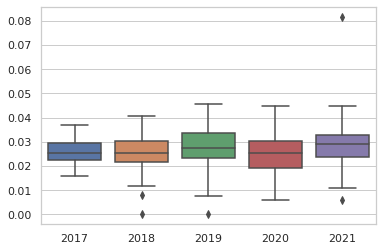

In [29]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(data=GasPricesHousehold)

### Datos de los costes del gas para empresas


Sustituimos NaN values por su media

In [30]:
GasPricesNoHousehold=data_gas_prices_no_household_consumers

median = GasPricesNoHousehold.loc[GasPricesNoHousehold['2020']<1, '2020'].median()
GasPricesNoHousehold.fillna(median,inplace=True)

median = GasPricesNoHousehold.loc[GasPricesNoHousehold['2019']<1, '2019'].median()
GasPricesNoHousehold.fillna(median,inplace=True)

median = GasPricesNoHousehold.loc[GasPricesNoHousehold['2018']<1, '2018'].median()
GasPricesNoHousehold.fillna(median,inplace=True)

median = GasPricesNoHousehold.loc[GasPricesNoHousehold['2017']<1, '2017'].median()
GasPricesNoHousehold.fillna(median,inplace=True)

Se muestran los 10 primero valores:

In [31]:
display(GasPricesNoHousehold.head(10))

,country,country_name,2017,2018,2019,2020,2021
0,AT,Austria,0.0168,0.0168,0.0184,0.0168,0.0297
1,BA,Bosnia and Herzegovina,0.0168,0.0168,0.0257,0.0259,0.0248
2,BE,Belgium,0.0168,0.0168,0.0189,0.0148,0.0318
3,BG,Bulgaria,0.0168,0.0168,0.0213,0.0142,0.0299
4,CZ,Czechia,0.0168,0.0168,0.0226,0.0192,0.0259
5,DE,Germany (until 1990 former territory of the FRG),0.0168,0.0168,0.0196,0.0171,0.0262
6,DK,Denmark,0.0194,0.0234,0.0178,0.0137,0.0448
7,EA,"Euro area (EA11-1999, EA12-2001, EA13-2007, EA...",0.0220,0.0240,0.0211,0.0175,0.0168
8,EE,Estonia,0.0168,0.0168,0.0213,0.0155,0.0352
9,EL,Greece,0.0168,0.0168,0.0260,0.0165,0.0337


Diagrama de caja para los diferentes años:

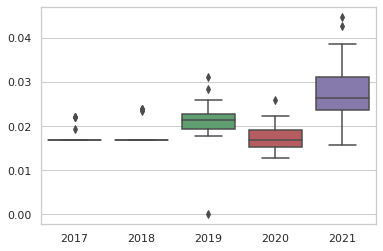

In [32]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(data=GasPricesNoHousehold)

### Datos de los costes de la electricidad doméstica


Se eliminan las columnas correspondientes a los valores semestrales de lo años desde el 2012 al 2016 que no contienen datos

In [33]:
ElectPricesHouseholds=data_electricity_prices_household_consumers.drop(['2012-S2','2013-S2','2014-S2','2015-S2','2016-S2'], axis=1)

Muestra de los 10 primeros valores

In [34]:
display(ElectPricesHouseholds.head( 10 ) )

,country,country_name,2017,2018,2019,2020,2021
0,AL,Albania,0.0713,0.0759,0.0778,NaN,0.0781
1,AT,Austria,0.0613,0.0623,0.0687,0.0732,0.0745
2,BA,Bosnia and Herzegovina,0.0342,0.0338,0.0361,0.0365,NaN
3,BE,Belgium,0.0735,0.0808,0.0859,0.0786,0.0844
4,BG,Bulgaria,0.0575,0.0585,0.0558,0.0560,0.0608
5,CY,Cyprus,0.1036,0.1157,0.1241,0.1042,0.1094
6,CZ,Czechia,0.0541,0.0570,0.0690,0.0749,0.0979
7,DE,Germany (until 1990 former territory of the FRG),0.0686,0.0622,0.0581,0.0574,0.0803
8,DK,Denmark,0.0388,0.0503,0.0539,0.0409,0.0747
9,EA,"Euro area (EA11-1999, EA12-2001, EA13-2007, EA...",0.0760,0.0801,0.0727,0.0697,NaN


Se muestra el diagrama de caja

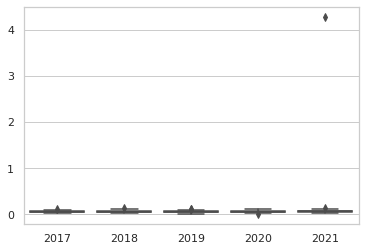

In [35]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(data=ElectPricesHouseholds)

Detectamos Outlier y Nans, lo sustituimos por la media en cada caso

In [36]:
median = ElectPricesHouseholds.loc[ElectPricesHouseholds['2021']<1, '2021'].median()
ElectPricesHouseholds.loc[ElectPricesHouseholds['2021'] > 1, '2021'] = np.nan
ElectPricesHouseholds.fillna(median,inplace=True)

median = ElectPricesHouseholds.loc[ElectPricesHouseholds['2020']<1, '2020'].median()
ElectPricesHouseholds.fillna(median,inplace=True)

median = ElectPricesHouseholds.loc[ElectPricesHouseholds['2019']<1, '2019'].median()
ElectPricesHouseholds.fillna(median,inplace=True)

median = ElectPricesHouseholds.loc[ElectPricesHouseholds['2018']<1, '2018'].median()
ElectPricesHouseholds.fillna(median,inplace=True)

median = ElectPricesHouseholds.loc[ElectPricesHouseholds['2017']<1, '2017'].median()
ElectPricesHouseholds.fillna(median,inplace=True)


Se vuelve a mostrar el diagrama de caja

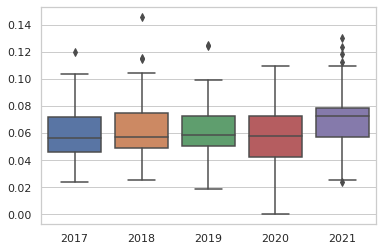

In [37]:
ax = sns.boxplot(data=ElectPricesHouseholds)

### Datos de los costes de la electricidad para empresas


Se eliminan las columnas correspondientes a los valores semestrales de lo años desde el 2012 al 2016 que no contienen datos

In [38]:
ElectPricesNoHouseholds=data_electricity_prices_no_household_consumers.drop(['2007-S2','2008-S2','2009-S2','2010-S2','2011-S2','2012-S2','2013-S2','2014-S2','2015-S2','2016-S2'], axis=1)

Se muestra el diagrama de caja

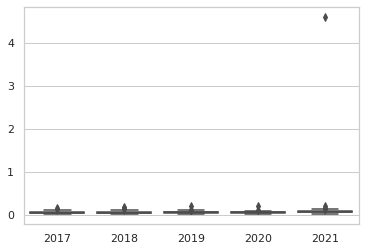

In [39]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(data=ElectPricesNoHouseholds)

Muestra de los 10 primeros valores

In [40]:
display( ElectPricesNoHouseholds.head( 10 ) )

,country,country_name,2017,2018,2019,2020,2021
0,AT,Austria,0.0598,0.0610,0.0654,0.0702,0.0723
1,BA,Bosnia and Herzegovina,0.0649,0.0621,0.0624,0.0648,NaN
2,BE,Belgium,0.0672,0.0624,0.0663,0.0745,0.0890
3,BG,Bulgaria,0.0817,0.0810,0.0764,0.0730,0.1075
4,CY,Cyprus,0.1187,0.1240,0.1271,0.1055,0.1136
5,CZ,Czechia,0.0580,0.0602,0.0721,0.0811,0.0848
6,DE,Germany (until 1990 former territory of the FRG),0.0468,0.0612,0.0525,0.0651,0.0707
7,DK,Denmark,0.0433,0.0514,0.0517,0.0426,0.0898
8,EA,"Euro area (EA11-1999, EA12-2001, EA13-2007, EA...",0.0757,0.0837,0.0794,0.0780,NaN
9,EE,Estonia,0.0406,0.0489,0.0516,0.0440,0.0850


Detectamos Outlier y Nans, lo sustituimos por la media en cada caso

In [41]:
median = ElectPricesNoHouseholds.loc[ElectPricesNoHouseholds['2021']<1, '2021'].median()
ElectPricesNoHouseholds.loc[ElectPricesNoHouseholds['2021'] > 1, '2021'] = np.nan
ElectPricesNoHouseholds.fillna(median,inplace=True)

median = ElectPricesNoHouseholds.loc[ElectPricesNoHouseholds['2020']<1, '2020'].median()
ElectPricesNoHouseholds.fillna(median,inplace=True)

median = ElectPricesNoHouseholds.loc[ElectPricesNoHouseholds['2019']<1, '2019'].median()
ElectPricesNoHouseholds.fillna(median,inplace=True)

median = ElectPricesNoHouseholds.loc[ElectPricesNoHouseholds['2018']<1, '2018'].median()
ElectPricesNoHouseholds.fillna(median,inplace=True)

median = ElectPricesNoHouseholds.loc[ElectPricesNoHouseholds['2017']<1, '2017'].median()
ElectPricesNoHouseholds.fillna(median,inplace=True)


Se vuelve a mostrar el diagrama de caja

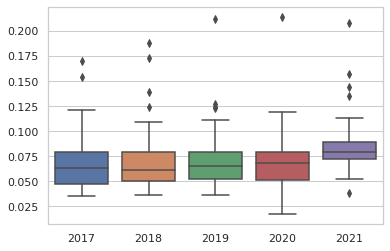

In [42]:
ax = sns.boxplot(data=ElectPricesNoHouseholds)

### _Conclusión de análisis inicial de datos:_
Descartamos continuar el análisis de House Hold, ya que los datsets obtenidos contienen una muestra demasiada pequeña para "Gas".

# Generación del dataset Final de trabajo

Generamos El Dataset final a exportar, con los datos posibles 

In [43]:
dElectCol = pd.merge(
    ElectPricesHouseholds.drop(['country_name'], axis=1), 
    ElectPricesNoHouseholds.drop(['country_name'], axis=1), 
    on='country',
    suffixes=('_ElectHouse', '_ElectNoHouse')
)

dGasCol = pd.merge(
    GasPricesHousehold.drop(['country_name'], axis=1), 
    GasPricesNoHousehold.drop(['country_name'], axis=1), 
    on='country',
    suffixes=('_GasHouse', '_GasNoHouse')
)

dEnergyCol = pd.merge(
    dElectCol, 
    dGasCol, 
    on='country'
)



Mostramos el dataset final a publicar, que no será el mismo que utilizemos para analizar

In [44]:
dEnergyCol

,country,2017_ElectHouse,2018_ElectHouse,2019_ElectHouse,2020_ElectHouse,2021_ElectHouse,2017_ElectNoHouse,2018_ElectNoHouse,2019_ElectNoHouse,2020_ElectNoHouse,...,2017_GasHouse,2018_GasHouse,2019_GasHouse,2020_GasHouse,2021_GasHouse,2017_GasNoHouse,2018_GasNoHouse,2019_GasNoHouse,2020_GasNoHouse,2021_GasNoHouse
0,AT,0.0613,0.0623,0.0687,0.0732,0.0745,0.0598,0.0610,0.0654,0.0702,...,0.02990,0.03040,0.0312,0.03080,0.03160,0.0168,0.0168,0.0184,0.0168,0.0297
1,BA,0.0342,0.0338,0.0361,0.0365,0.0726,0.0649,0.0621,0.0624,0.0648,...,0.02400,0.02400,0.0249,0.02580,0.02510,0.0168,0.0168,0.0257,0.0259,0.0248
2,BE,0.0735,0.0808,0.0859,0.0786,0.0844,0.0672,0.0624,0.0663,0.0745,...,0.02830,0.02880,0.0289,0.02520,0.03150,0.0168,0.0168,0.0189,0.0148,0.0318
3,BG,0.0575,0.0585,0.0558,0.0560,0.0608,0.0817,0.0810,0.0764,0.0730,...,0.01700,0.02090,0.0240,0.01770,0.03310,0.0168,0.0168,0.0213,0.0142,0.0299
4,CZ,0.0541,0.0570,0.0690,0.0749,0.0979,0.0580,0.0602,0.0721,0.0811,...,0.03600,0.03900,0.0455,0.04310,0.04480,0.0168,0.0168,0.0226,0.0192,0.0259
5,DE,0.0686,0.0622,0.0581,0.0574,0.0803,0.0468,0.0612,0.0525,0.0651,...,0.02555,0.02555,0.0278,0.02920,0.02930,0.0168,0.0168,0.0196,0.0171,0.0262
6,DK,0.0388,0.0503,0.0539,0.0409,0.0747,0.0433,0.0514,0.0517,0.0426,...,0.02340,0.02590,0.0209,0.01600,0.04150,0.0194,0.0234,0.0178,0.0137,0.0448
7,EA,0.0760,0.0801,0.0727,0.0697,0.0726,0.0757,0.0837,0.0794,0.0780,...,0.02950,0.03030,0.0319,0.03020,0.02555,0.0220,0.0240,0.0211,0.0175,0.0168
8,EE,0.0442,0.0518,0.0533,0.0444,0.0764,0.0406,0.0489,0.0516,0.0440,...,0.02340,0.02390,0.0253,0.02400,0.03610,0.0168,0.0168,0.0213,0.0155,0.0352
9,EL,0.0840,0.0863,0.0900,0.1021,0.1182,0.0810,0.0876,0.0912,0.0933,...,0.02555,0.03110,0.0338,0.02580,0.04440,0.0168,0.0168,0.0260,0.0165,0.0337


Construimos un Dataset Final para proceder a analizar con los precio de Gas y Electricidad desde 2017 hasta 2021, una vez se han arreglado los datos y se ha descartado el de No House Hold (Profesional)

In [45]:
dEnergyHouseCol = pd.merge(
    ElectPricesHouseholds.drop(['country_name'], axis=1), 
    GasPricesHousehold.drop(['country_name'], axis=1), 
    on='country',
    suffixes=('_ElectHouse', '_GasHouse')
)


Se añade la columna del nombre del país

In [46]:
dEnergyHouseCol= column_country_name( dEnergyHouseCol )
dEnergyCol= column_country_name( dEnergyCol )

Columnas del dataset a Publicar:

In [47]:
display( dEnergyCol.dtypes )

country               object
country_name          object
2017_ElectHouse      float64
2018_ElectHouse      float64
2019_ElectHouse      float64
2020_ElectHouse      float64
2021_ElectHouse      float64
2017_ElectNoHouse    float64
2018_ElectNoHouse    float64
2019_ElectNoHouse    float64
2020_ElectNoHouse    float64
2021_ElectNoHouse    float64
2017_GasHouse        float64
2018_GasHouse        float64
2019_GasHouse        float64
2020_GasHouse        float64
2021_GasHouse        float64
2017_GasNoHouse      float64
2018_GasNoHouse      float64
2019_GasNoHouse      float64
2020_GasNoHouse      float64
2021_GasNoHouse      float64
dtype: object

Columnas del dataset a Analizar:

In [48]:
display( dEnergyHouseCol.dtypes )

country             object
country_name        object
2017_ElectHouse    float64
2018_ElectHouse    float64
2019_ElectHouse    float64
2020_ElectHouse    float64
2021_ElectHouse    float64
2017_GasHouse      float64
2018_GasHouse      float64
2019_GasHouse      float64
2020_GasHouse      float64
2021_GasHouse      float64
dtype: object

## Exportación dataset Final en formato CSV

In [49]:
export_dataframe( 
    df = dEnergyCol, 
    file_name = 'dataset', 
    directory = 'dataset' 
) 

## Preparación y generación de datasets para Analizar

##### Eliminamos el valor "EU27_2020"

In [50]:
dEnergyHouseTemp = dEnergyHouseCol.loc[(dEnergyHouseCol["country"] != "EU27_2020")]

##### Trasponemos y recreamos el dataset para prepararlo para una nueva presentación multivariable

In [51]:
dEnergyHouseDummy_2017=  dEnergyHouseTemp.loc[:,['country', '2017_ElectHouse']]
dEnergyHouseDummy_2017['Year']=2017
dEnergyHouseDummy_2017['Type']='Electricity'
dEnergyHouseDummy_2018=  dEnergyHouseTemp.loc[:,['country', '2018_ElectHouse']]
dEnergyHouseDummy_2018['Year']=2018
dEnergyHouseDummy_2018['Type']='Electricity'
dEnergyHouseDummy_2019=  dEnergyHouseTemp.loc[:,['country', '2019_ElectHouse']]
dEnergyHouseDummy_2019['Year']=2019
dEnergyHouseDummy_2019['Type']='Electricity'
dEnergyHouseDummy_2020=  dEnergyHouseTemp.loc[:,['country', '2020_ElectHouse']]
dEnergyHouseDummy_2020['Year']=2020
dEnergyHouseDummy_2020['Type']='Electricity'
dEnergyHouseDummy_2021= dEnergyHouseTemp.loc[:,['country', '2021_ElectHouse']]
dEnergyHouseDummy_2021['Year']=2021
dEnergyHouseDummy_2021['Type']='Electricity'

dGasHouseDummy_2017=  dEnergyHouseTemp.loc[:,['country', '2017_GasHouse']]
dGasHouseDummy_2017['Year']=2017
dGasHouseDummy_2017['Type']='Gas'
dGasHouseDummy_2018=  dEnergyHouseTemp.loc[:,['country', '2018_GasHouse']]
dGasHouseDummy_2018['Year']=2018
dGasHouseDummy_2018['Type']='Gas'
dGasHouseDummy_2019=  dEnergyHouseTemp.loc[:,['country', '2019_GasHouse']]
dGasHouseDummy_2019['Year']=2019
dGasHouseDummy_2019['Type']='Gas'
dGasHouseDummy_2020=  dEnergyHouseTemp.loc[:,['country', '2020_GasHouse']]
dGasHouseDummy_2020['Year']=2020
dGasHouseDummy_2020['Type']='Gas'
dGasHouseDummy_2021= dEnergyHouseTemp.loc[:,['country', '2021_GasHouse']]
dGasHouseDummy_2021['Year']=2021
dGasHouseDummy_2021['Type']='Gas'


In [52]:
dEnergyHouseDummy_2017=dEnergyHouseDummy_2017.rename(columns={"2017_ElectHouse": "Price"})
dEnergyHouseDummy_2018=dEnergyHouseDummy_2018.rename(columns={"2018_ElectHouse": "Price"})
dEnergyHouseDummy_2019=dEnergyHouseDummy_2019.rename(columns={"2019_ElectHouse": "Price"})
dEnergyHouseDummy_2020=dEnergyHouseDummy_2020.rename(columns={"2020_ElectHouse": "Price"})
dEnergyHouseDummy_2021=dEnergyHouseDummy_2021.rename(columns={"2021_ElectHouse": "Price"})
dGasHouseDummy_2017=dGasHouseDummy_2017.rename(columns={"2017_GasHouse": "Price"})
dGasHouseDummy_2018=dGasHouseDummy_2018.rename(columns={"2018_GasHouse": "Price"})
dGasHouseDummy_2019=dGasHouseDummy_2019.rename(columns={"2019_GasHouse": "Price"})
dGasHouseDummy_2020=dGasHouseDummy_2020.rename(columns={"2020_GasHouse": "Price"})
dGasHouseDummy_2021=dGasHouseDummy_2021.rename(columns={"2021_GasHouse": "Price"})


dEnergyHouse = pd.concat(
        [
            dEnergyHouseDummy_2017,
            dEnergyHouseDummy_2018,
            dEnergyHouseDummy_2019,
            dEnergyHouseDummy_2020,
            dEnergyHouseDummy_2021,
            dGasHouseDummy_2017,
            dGasHouseDummy_2018,
            dGasHouseDummy_2019,
            dGasHouseDummy_2020,
            dGasHouseDummy_2021
        ]

    )

display(dEnergyHouse)

,country,Price,Year,Type
0,AT,0.06130,2017,Electricity
1,BA,0.03420,2017,Electricity
2,BE,0.07350,2017,Electricity
3,BG,0.05750,2017,Electricity
4,CZ,0.05410,2017,Electricity
...,...,...,...,...
30,SI,0.02640,2021,Gas
31,SK,0.01950,2021,Gas
32,TR,0.01100,2021,Gas
33,UA,0.02555,2021,Gas


## Análisis Visual de la información

### Total de Coste de Tipo de Energía por paises en los 4 últimos años

<AxesSubplot:xlabel='country', ylabel='Price'>

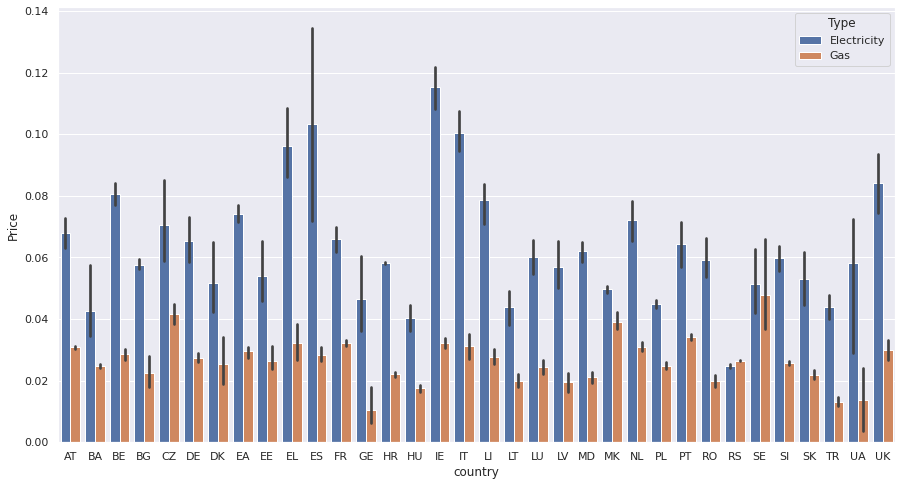

In [53]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.barplot(x='country', y='Price', hue='Type', data=dEnergyHouse, saturation=0.8)


#### Conclusiones de Análisis Visual

Teniendo en cuenta la información contenida en el siguiente Link del Banco Mundial, donde podemos obtner el PIB de cualquier país

In [54]:
IFrame(src="https://datos.bancomundial.org/share/widget?indicators=NY.GDP.PCAP.CD&view=map", width='450', height='300', frameBorder='0', scrolling="no")

https://datos.bancomundial.org/share/widget?indicators=NY.GDP.PCAP.CD&view=map

Obtenemos conclusiones como que por Ejemplo, España siendo uno de los paises con peor PIB de Europa, tiene uno de los costes acumulados históricos de los últimos 4 años más altos de Europa. 
O que Países con PIB más alto de la Comunidad Europea como Alemania (GE) o Austria (AT) tienen de los precios más bajos del continente Europes.
Así mismo se observa una varianza reseñable en los precios de la Electricidad por cada país, que no se observa de una forma equivalente en el Gas.

### Detalle histórico de los 4 últimos años de coste por tipo de Energía y país

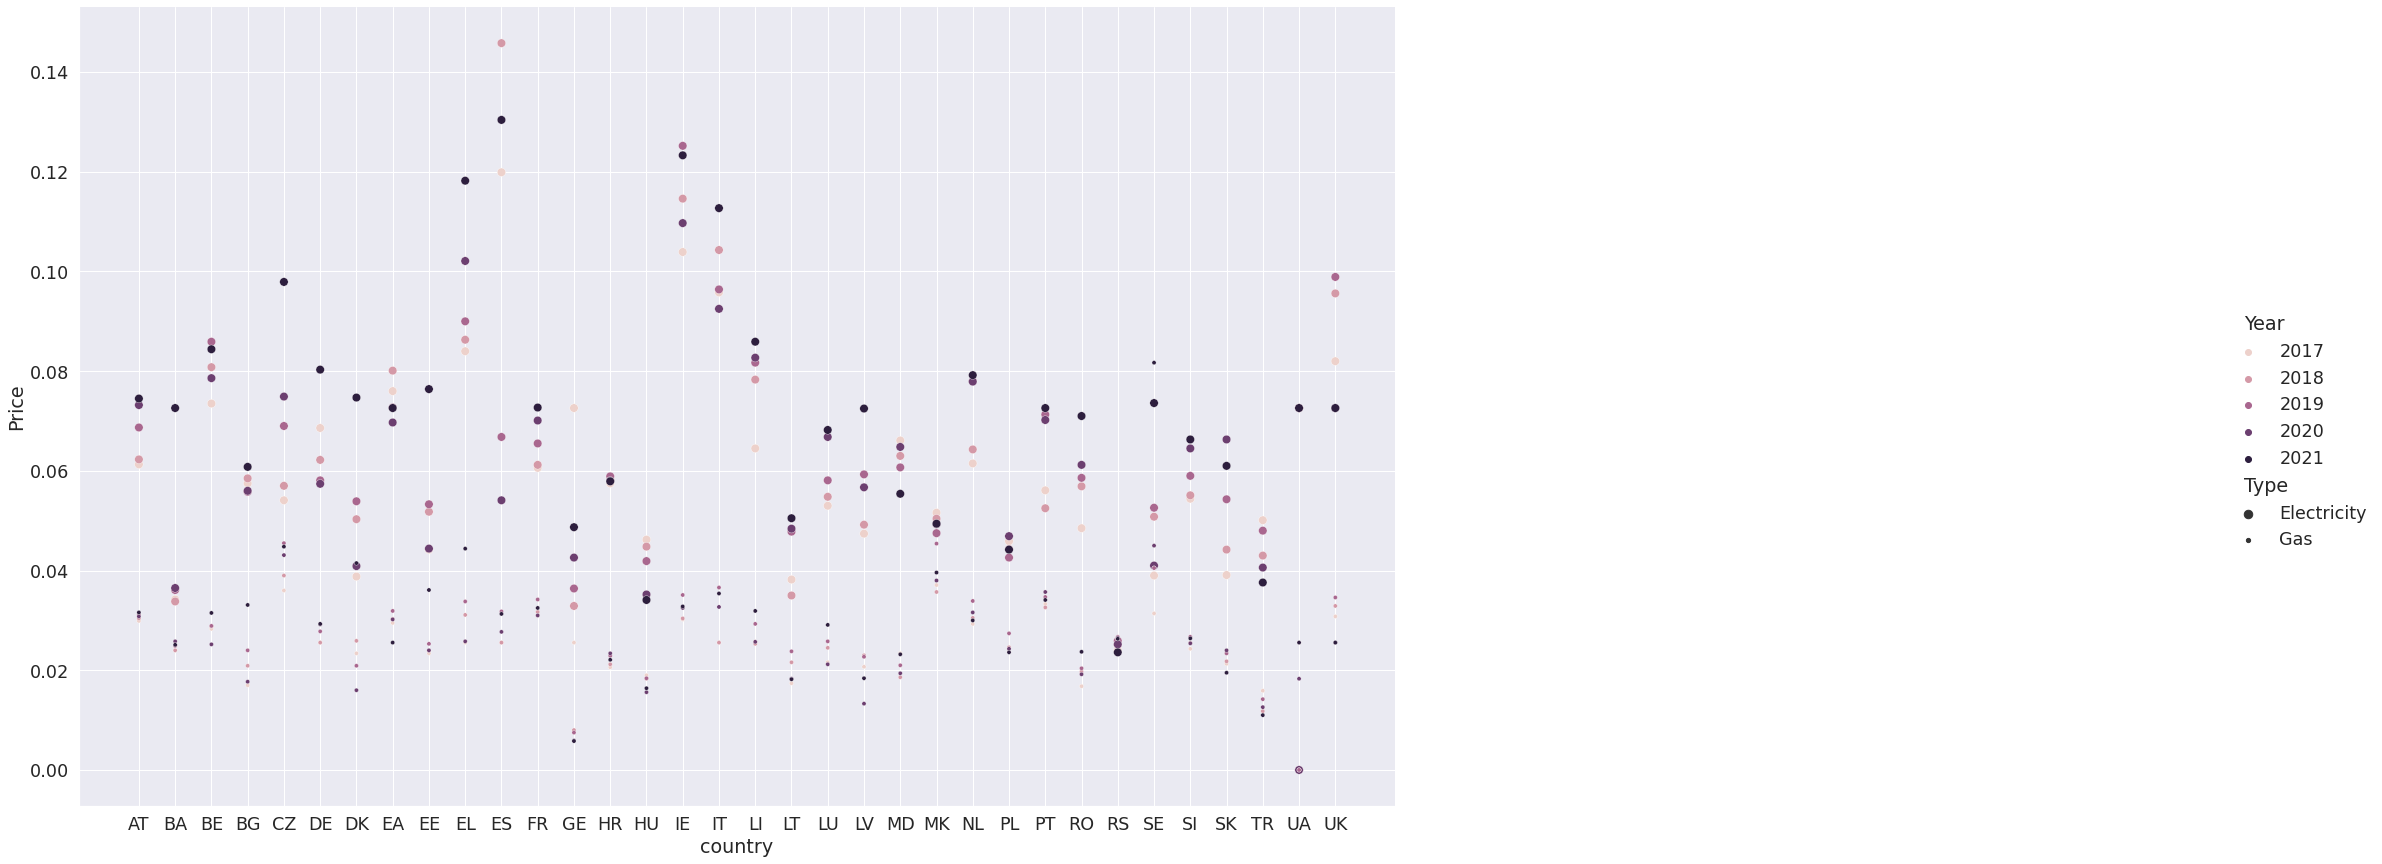

In [55]:
dEnergyHouseElect=dEnergyHouse[(dEnergyHouse['Type'] == 'Electricidad') ]
dEnergyHouseGas=dEnergyHouse[(dEnergyHouse['Type'] == 'Gas') ]


sns.set(font_scale = 1.60)
g=sns.relplot(data=dEnergyHouse, x='country', y='Price', size='Type', hue="Year")
g.fig.set_size_inches(45,15)

#### Conclusiones de Análisis Visual

Alemania mantiene constante practicamente su coste de Gas igual en los últimos 4 años, España marca máximo histórico en Gas y su segundo máximo en Electricidad, teniendo una varianza reseñable anual en los precios. Reino Unido tiene el precio más bajo en Electricidad y Gas de los últimos 4 años.